In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset
import gymnasium as gym

from astropy.io import fits
from datetime import datetime
import json
# import fitsio
import pandas as pd
import time
import pickle

%reload_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('/home/rachel/Projects/survey-ops/')


In [3]:
import survey_ops
from survey_ops.utils import units, geometry, interpolate
from survey_ops.src.environments import *
from survey_ops.src.offline_dataset import OfflineDECamDataset
from survey_ops.src.agents import Agent
from survey_ops.src.algorithms import DDQN, BehaviorCloning
from survey_ops.utils.pytorch_utils import seed_everything


In [4]:
seed_everything(10)

# Load and cut data from fits file, save as .json

In [5]:
data_json_fn = '../data/data.json'
data_fits_fn = '../data/decam-exposures-20251107.fits.gz'

try:
    # --- Load json df ---- #
    df = pd.read_json(data_json_fn)
    print('Loaded data from json')
except:
    # --- Load fits ---- #
    print(data_json_fn, 'DNE. Loading and processing data from fits.')
    d = fitsio.read('../data/decam-exposures-20251107.fits.gz')
    sel = (d['propid'] == '2012B-0001') & (d['exptime'] > 40) & (d['exptime'] < 100) & (~np.isnan(d['teff']))
    selected_d = d[sel]
    column_names = selected_d.dtype.names
    df = pd.DataFrame(selected_d, columns=column_names)
    print(df['datetime'].dtype)
    
    # mask = np.array([False if 'None' in dt else True for dt in subs_data['datetime']])
    # subs_data = {key: subs_data[key][mask] for key in subs_data.keys()}
    
    df.to_json(data_json_fn, indent=2)
    df = pd.read_json(data_json_fn)
    

Loaded data from json


# Configure model, data selection, and training setup

In [6]:
SEED = 10
seed_everything(SEED)
torch.set_default_dtype(torch.float32)
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "cpu"   
)

In [7]:
dataset = OfflineDECamDataset(
    df, 
    normalize_state=True,
    specific_years=[2013],
    specific_months=[8, 9],
    specific_days=[31, 1, 2],
    # specific_years=[2014],

    binning_method='healpix',
    nside=8,
    bin_space='radec'
    # specific_days=np.arange(2, 4),
    # specific_filters=['r', 'g']
)

In [8]:
dataset.num_transitions

444

In [9]:
batch_size = 64
num_workers = 4
pin_memory = True if device == 'cuda' else False
trainloader = dataset.get_dataloader(batch_size, num_workers = num_workers, pin_memory = pin_memory)


In [45]:
"""Algorithm and Train setup"""

alg_config = {
    'obs_dim': dataset.obs_dim,
    'num_actions': dataset.num_actions,
    'hidden_dim': 64,
    'device': device,
    'lr': 1e-4,
    'loss_fxn': torch.nn.functional.huber_loss, # use default
    'gamma': .4,
    'tau': 5e-4,
    'use_double': False,
    'weight_decay': 1e-4
}
    
alg = DDQN(**alg_config)

fit_config = {
    'num_epochs' : 20,
    'batch_size': batch_size,
    # 'learning_start': 
    }

env_name = 'TelescopeEnv-v0'

def create_exp_name(alg, env_name, dataset, fit_config, alg_config):
    exp_name = f"{alg.name}"
    exp_name += f"-{env_name}"
    exp_name += f"-n_nights={dataset.n_nights}"
    # config_prefix += f"-use_double={alg_config['use_double']}"
    exp_name += f"-num_epochs={fit_config['num_epochs']}"
    exp_name += f"-batch_size={fit_config['batch_size']}"
    exp_name += f"-lr={alg_config['lr']}"
    return exp_name

exp_name = create_exp_name(alg, env_name, dataset, fit_config, alg_config)

outdir = f'../results/{exp_name}/'
if not os.path.exists(outdir):
    os.makedirs(outdir)
fig_outdir = outdir + 'figures/'
if not os.path.exists(fig_outdir):
    os.makedirs(fig_outdir)

agent_config = {
    'algorithm': alg,
    'normalize_obs': dataset.normalize_state,
    'outdir': outdir
    }

agent = Agent(**agent_config)



# Train

In [46]:
start_time = time.time()
"""Train"""
agent.fit(
    dataloader=trainloader,
    **fit_config
    )
end_time = time.time()
train_time = end_time - start_time
print(f'Total train time = {train_time}s')

  0%|                                        | 27/8880 [00:00<00:58, 151.89it/s]

Train step 0: Accuracy = 0.000, Loss = 0.1531, Q-val=-0.028


  2%|▋                                      | 144/8880 [00:00<00:32, 272.63it/s]

Train step 100: Accuracy = 0.000, Loss = 0.0904, Q-val=0.122


  3%|█                                      | 231/8880 [00:00<00:30, 280.15it/s]

Train step 200: Accuracy = 0.047, Loss = 0.0262, Q-val=0.335


  4%|█▌                                     | 344/8880 [00:01<00:32, 266.23it/s]

Train step 300: Accuracy = 0.016, Loss = 0.0131, Q-val=0.376


  5%|█▉                                     | 433/8880 [00:01<00:29, 283.59it/s]

Train step 400: Accuracy = 0.016, Loss = 0.0067, Q-val=0.441


  6%|██▍                                    | 553/8880 [00:02<00:28, 291.91it/s]

Train step 500: Accuracy = 0.000, Loss = 0.0077, Q-val=0.460


  7%|██▊                                    | 644/8880 [00:02<00:28, 285.91it/s]

Train step 600: Accuracy = 0.031, Loss = 0.0040, Q-val=0.457


  8%|███▏                                   | 734/8880 [00:02<00:28, 290.01it/s]

Train step 700: Accuracy = 0.047, Loss = 0.0035, Q-val=0.491


 10%|███▊                                   | 855/8880 [00:03<00:26, 297.93it/s]

Train step 800: Accuracy = 0.000, Loss = 0.0045, Q-val=0.504


 11%|████▏                                  | 946/8880 [00:03<00:26, 294.55it/s]

Train step 900: Accuracy = 0.000, Loss = 0.0021, Q-val=0.507


 12%|████▍                                 | 1035/8880 [00:03<00:27, 283.87it/s]

Train step 1000: Accuracy = 0.000, Loss = 0.0032, Q-val=0.467


 13%|████▉                                 | 1156/8880 [00:04<00:25, 298.23it/s]

Train step 1100: Accuracy = 0.000, Loss = 0.0054, Q-val=0.509


 14%|█████▎                                | 1247/8880 [00:04<00:26, 287.31it/s]

Train step 1200: Accuracy = 0.016, Loss = 0.0046, Q-val=0.502


 15%|█████▋                                | 1336/8880 [00:04<00:26, 286.77it/s]

Train step 1300: Accuracy = 0.000, Loss = 0.0029, Q-val=0.496


 16%|██████▏                               | 1448/8880 [00:05<00:27, 267.31it/s]

Train step 1400: Accuracy = 0.031, Loss = 0.0042, Q-val=0.539


 17%|██████▌                               | 1534/8880 [00:05<00:26, 276.07it/s]

Train step 1500: Accuracy = 0.062, Loss = 0.0037, Q-val=0.516


 19%|███████                               | 1648/8880 [00:05<00:25, 278.97it/s]

Train step 1600: Accuracy = 0.016, Loss = 0.0061, Q-val=0.498


 20%|███████▍                              | 1736/8880 [00:06<00:25, 283.86it/s]

Train step 1700: Accuracy = 0.000, Loss = 0.0023, Q-val=0.529


 21%|███████▉                              | 1857/8880 [00:06<00:24, 289.08it/s]

Train step 1800: Accuracy = 0.000, Loss = 0.0025, Q-val=0.511


 22%|████████▎                             | 1944/8880 [00:06<00:24, 280.21it/s]

Train step 1900: Accuracy = 0.016, Loss = 0.0035, Q-val=0.488


 23%|████████▋                             | 2032/8880 [00:07<00:24, 283.73it/s]

Train step 2000: Accuracy = 0.047, Loss = 0.0019, Q-val=0.506


 24%|█████████▏                            | 2145/8880 [00:07<00:25, 264.58it/s]

Train step 2100: Accuracy = 0.047, Loss = 0.0041, Q-val=0.514


 25%|█████████▌                            | 2225/8880 [00:08<00:26, 248.37it/s]

Train step 2200: Accuracy = 0.016, Loss = 0.0022, Q-val=0.524


 26%|█████████▉                            | 2335/8880 [00:08<00:24, 264.31it/s]

Train step 2300: Accuracy = 0.016, Loss = 0.0022, Q-val=0.516


 28%|██████████▍                           | 2444/8880 [00:08<00:24, 265.51it/s]

Train step 2400: Accuracy = 0.062, Loss = 0.0040, Q-val=0.563


 29%|██████████▉                           | 2555/8880 [00:09<00:23, 269.36it/s]

Train step 2500: Accuracy = 0.031, Loss = 0.0024, Q-val=0.512


 30%|███████████▎                          | 2638/8880 [00:09<00:23, 265.30it/s]

Train step 2600: Accuracy = 0.031, Loss = 0.0030, Q-val=0.575


 31%|███████████▋                          | 2745/8880 [00:10<00:24, 254.57it/s]

Train step 2700: Accuracy = 0.078, Loss = 0.0025, Q-val=0.541


 32%|████████████▏                         | 2835/8880 [00:10<00:21, 282.67it/s]

Train step 2800: Accuracy = 0.016, Loss = 0.0026, Q-val=0.560


 33%|████████████▋                         | 2951/8880 [00:10<00:20, 283.49it/s]

Train step 2900: Accuracy = 0.062, Loss = 0.0019, Q-val=0.585


 34%|█████████████                         | 3039/8880 [00:11<00:21, 276.21it/s]

Train step 3000: Accuracy = 0.047, Loss = 0.0025, Q-val=0.531


 35%|█████████████▍                        | 3150/8880 [00:11<00:21, 267.17it/s]

Train step 3100: Accuracy = 0.062, Loss = 0.0040, Q-val=0.498


 36%|█████████████▊                        | 3234/8880 [00:11<00:20, 273.91it/s]

Train step 3200: Accuracy = 0.047, Loss = 0.0035, Q-val=0.571


 38%|██████████████▎                       | 3348/8880 [00:12<00:19, 280.26it/s]

Train step 3300: Accuracy = 0.047, Loss = 0.0015, Q-val=0.513


 39%|██████████████▋                       | 3433/8880 [00:12<00:20, 271.16it/s]

Train step 3400: Accuracy = 0.062, Loss = 0.0015, Q-val=0.548


 40%|███████████████▏                      | 3546/8880 [00:12<00:19, 276.67it/s]

Train step 3500: Accuracy = 0.031, Loss = 0.0029, Q-val=0.527


 41%|███████████████▌                      | 3630/8880 [00:13<00:19, 270.63it/s]

Train step 3600: Accuracy = 0.062, Loss = 0.0027, Q-val=0.610


 42%|████████████████                      | 3740/8880 [00:13<00:19, 265.31it/s]

Train step 3700: Accuracy = 0.047, Loss = 0.0024, Q-val=0.532


 43%|████████████████▍                     | 3852/8880 [00:14<00:18, 274.82it/s]

Train step 3800: Accuracy = 0.000, Loss = 0.0018, Q-val=0.567


 44%|████████████████▊                     | 3934/8880 [00:14<00:18, 261.01it/s]

Train step 3900: Accuracy = 0.062, Loss = 0.0031, Q-val=0.547


 46%|█████████████████▎                    | 4048/8880 [00:14<00:17, 275.23it/s]

Train step 4000: Accuracy = 0.047, Loss = 0.0016, Q-val=0.555


 47%|█████████████████▋                    | 4132/8880 [00:15<00:17, 267.92it/s]

Train step 4100: Accuracy = 0.016, Loss = 0.0030, Q-val=0.583


 48%|██████████████████▏                   | 4244/8880 [00:15<00:18, 255.23it/s]

Train step 4200: Accuracy = 0.016, Loss = 0.0033, Q-val=0.579


 49%|██████████████████▋                   | 4355/8880 [00:15<00:16, 270.11it/s]

Train step 4300: Accuracy = 0.016, Loss = 0.0014, Q-val=0.561


 50%|██████████████████▉                   | 4439/8880 [00:16<00:16, 268.09it/s]

Train step 4400: Accuracy = 0.000, Loss = 0.0021, Q-val=0.586


 51%|███████████████████▍                  | 4554/8880 [00:16<00:15, 278.54it/s]

Train step 4500: Accuracy = 0.000, Loss = 0.0016, Q-val=0.571


 52%|███████████████████▊                  | 4635/8880 [00:17<00:16, 255.89it/s]

Train step 4600: Accuracy = 0.047, Loss = 0.0033, Q-val=0.618


 53%|████████████████████▎                 | 4738/8880 [00:17<00:16, 244.38it/s]

Train step 4700: Accuracy = 0.016, Loss = 0.0020, Q-val=0.614


 55%|████████████████████▋                 | 4844/8880 [00:17<00:15, 255.82it/s]

Train step 4800: Accuracy = 0.016, Loss = 0.0026, Q-val=0.607


 56%|█████████████████████▏                | 4946/8880 [00:18<00:15, 247.19it/s]

Train step 4900: Accuracy = 0.047, Loss = 0.0033, Q-val=0.622


 57%|█████████████████████▌                | 5048/8880 [00:18<00:15, 244.79it/s]

Train step 5000: Accuracy = 0.031, Loss = 0.0019, Q-val=0.602


 58%|█████████████████████▉                | 5129/8880 [00:19<00:14, 257.31it/s]

Train step 5100: Accuracy = 0.047, Loss = 0.0013, Q-val=0.680


 59%|██████████████████████▍               | 5237/8880 [00:19<00:13, 262.50it/s]

Train step 5200: Accuracy = 0.047, Loss = 0.0021, Q-val=0.592


 60%|██████████████████████▊               | 5345/8880 [00:19<00:13, 263.08it/s]

Train step 5300: Accuracy = 0.062, Loss = 0.0015, Q-val=0.610


 61%|███████████████████████▎              | 5452/8880 [00:20<00:13, 256.87it/s]

Train step 5400: Accuracy = 0.047, Loss = 0.0015, Q-val=0.636


 62%|███████████████████████▋              | 5535/8880 [00:20<00:12, 267.29it/s]

Train step 5500: Accuracy = 0.016, Loss = 0.0017, Q-val=0.623


 64%|████████████████████████▏             | 5646/8880 [00:20<00:11, 270.60it/s]

Train step 5600: Accuracy = 0.016, Loss = 0.0022, Q-val=0.674


 65%|████████████████████████▌             | 5730/8880 [00:21<00:11, 271.53it/s]

Train step 5700: Accuracy = 0.016, Loss = 0.0033, Q-val=0.635


 66%|████████████████████████▉             | 5840/8880 [00:21<00:11, 258.70it/s]

Train step 5800: Accuracy = 0.016, Loss = 0.0016, Q-val=0.623


 67%|█████████████████████████▍            | 5950/8880 [00:22<00:10, 267.94it/s]

Train step 5900: Accuracy = 0.031, Loss = 0.0014, Q-val=0.667


 68%|█████████████████████████▊            | 6035/8880 [00:22<00:10, 276.86it/s]

Train step 6000: Accuracy = 0.016, Loss = 0.0016, Q-val=0.653


 69%|██████████████████████████▎           | 6148/8880 [00:22<00:10, 272.30it/s]

Train step 6100: Accuracy = 0.062, Loss = 0.0027, Q-val=0.636


 70%|██████████████████████████▋           | 6237/8880 [00:23<00:09, 286.18it/s]

Train step 6200: Accuracy = 0.062, Loss = 0.0028, Q-val=0.662


 71%|███████████████████████████           | 6327/8880 [00:23<00:09, 275.32it/s]

Train step 6300: Accuracy = 0.047, Loss = 0.0013, Q-val=0.638


 72%|███████████████████████████▌          | 6438/8880 [00:23<00:09, 263.72it/s]

Train step 6400: Accuracy = 0.000, Loss = 0.0018, Q-val=0.630


 74%|████████████████████████████          | 6554/8880 [00:24<00:08, 282.90it/s]

Train step 6500: Accuracy = 0.016, Loss = 0.0033, Q-val=0.661


 75%|████████████████████████████▍         | 6640/8880 [00:24<00:08, 256.99it/s]

Train step 6600: Accuracy = 0.031, Loss = 0.0019, Q-val=0.627


 76%|████████████████████████████▊         | 6744/8880 [00:25<00:08, 250.74it/s]

Train step 6700: Accuracy = 0.047, Loss = 0.0018, Q-val=0.650


 77%|█████████████████████████████▏        | 6829/8880 [00:25<00:07, 267.09it/s]

Train step 6800: Accuracy = 0.062, Loss = 0.0023, Q-val=0.602


 78%|█████████████████████████████▋        | 6940/8880 [00:25<00:08, 242.02it/s]

Train step 6900: Accuracy = 0.000, Loss = 0.0021, Q-val=0.683


 79%|██████████████████████████████▏       | 7055/8880 [00:26<00:06, 273.33it/s]

Train step 7000: Accuracy = 0.000, Loss = 0.0020, Q-val=0.653


 80%|██████████████████████████████▌       | 7142/8880 [00:26<00:06, 278.48it/s]

Train step 7100: Accuracy = 0.047, Loss = 0.0011, Q-val=0.709


 82%|███████████████████████████████       | 7256/8880 [00:26<00:05, 275.76it/s]

Train step 7200: Accuracy = 0.000, Loss = 0.0023, Q-val=0.664


 83%|███████████████████████████████▍      | 7343/8880 [00:27<00:05, 281.49it/s]

Train step 7300: Accuracy = 0.016, Loss = 0.0025, Q-val=0.708


 84%|███████████████████████████████▊      | 7426/8880 [00:27<00:06, 227.09it/s]

Train step 7400: Accuracy = 0.000, Loss = 0.0012, Q-val=0.658


 85%|████████████████████████████████▏     | 7532/8880 [00:28<00:05, 253.96it/s]

Train step 7500: Accuracy = 0.000, Loss = 0.0018, Q-val=0.621


 86%|████████████████████████████████▋     | 7647/8880 [00:28<00:04, 269.77it/s]

Train step 7600: Accuracy = 0.016, Loss = 0.0020, Q-val=0.641


 87%|█████████████████████████████████     | 7732/8880 [00:28<00:04, 267.70it/s]

Train step 7700: Accuracy = 0.016, Loss = 0.0023, Q-val=0.645


 88%|█████████████████████████████████▌    | 7844/8880 [00:29<00:03, 275.65it/s]

Train step 7800: Accuracy = 0.000, Loss = 0.0018, Q-val=0.695


 89%|█████████████████████████████████▉    | 7933/8880 [00:29<00:03, 286.22it/s]

Train step 7900: Accuracy = 0.047, Loss = 0.0020, Q-val=0.656


 90%|██████████████████████████████████▎   | 8023/8880 [00:29<00:03, 269.01it/s]

Train step 8000: Accuracy = 0.031, Loss = 0.0021, Q-val=0.725


 92%|██████████████████████████████████▊   | 8142/8880 [00:30<00:02, 271.20it/s]

Train step 8100: Accuracy = 0.031, Loss = 0.0017, Q-val=0.722


 93%|███████████████████████████████████▎  | 8255/8880 [00:30<00:02, 275.85it/s]

Train step 8200: Accuracy = 0.078, Loss = 0.0026, Q-val=0.661


 94%|███████████████████████████████████▋  | 8344/8880 [00:31<00:01, 286.99it/s]

Train step 8300: Accuracy = 0.016, Loss = 0.0019, Q-val=0.724


 95%|████████████████████████████████████  | 8432/8880 [00:31<00:01, 281.47it/s]

Train step 8400: Accuracy = 0.031, Loss = 0.0022, Q-val=0.696


 96%|████████████████████████████████████▌ | 8547/8880 [00:31<00:01, 279.06it/s]

Train step 8500: Accuracy = 0.000, Loss = 0.0031, Q-val=0.659


 97%|████████████████████████████████████▉ | 8635/8880 [00:32<00:00, 286.60it/s]

Train step 8600: Accuracy = 0.047, Loss = 0.0011, Q-val=0.622


 99%|█████████████████████████████████████▍| 8755/8880 [00:32<00:00, 293.83it/s]

Train step 8700: Accuracy = 0.016, Loss = 0.0019, Q-val=0.711


100%|█████████████████████████████████████▊| 8846/8880 [00:32<00:00, 296.19it/s]

Train step 8800: Accuracy = 0.047, Loss = 0.0010, Q-val=0.680


100%|██████████████████████████████████████| 8880/8880 [00:32<00:00, 270.06it/s]

Total train time = 33.014400482177734s


In [43]:
with open(outdir + 'train_metrics.pkl', 'rb') as handle:
    train_metrics = pickle.load(handle)

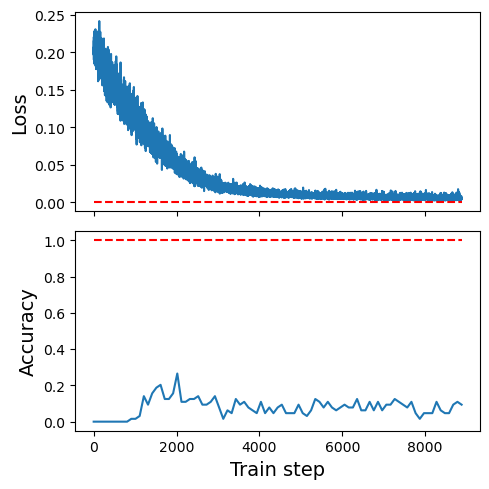

In [44]:
fig, axs = plt.subplots(2, sharex=True, figsize=(5, 5))
axs[0].plot(train_metrics['loss_history'])
axs[0].hlines(y=0, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[0].set_ylabel('Loss', fontsize=14)
axs[1].plot(np.linspace(0, len(train_metrics['loss_history']), len(train_metrics['test_acc_history'])), train_metrics['test_acc_history'])
axs[1].hlines(y=1, xmin=0, xmax=len(train_metrics['loss_history']), color='red', linestyle='--')
axs[1].set_xlabel('Train step', fontsize=14)
axs[1].set_ylabel('Accuracy', fontsize=14)
axs[1].set_xlabel('Train step', fontsize=14)
fig.tight_layout()
fig.savefig(fig_outdir + 'train_history.png')

In [35]:
dataset.num_transitions

444

# Evaluate

In [36]:
dataset._df

,expnum,ra,dec,exptime,filter,propid,program,teff,fwhm,datetime,az,zd,ha,airmass,qc_fwhm,qc_cloud,qc_sky,qc_teff,timestamp,night
0,229250,301.199036,-50.938332,90,g,2012B-0001,survey,0.277027,1.15,2013-08-31 23:55:07,139.550003,32.209999,-33.208458,1.18,1.15,0.42,1.26,0.41,1377993307,2013-08-31
1,229251,300.851105,-52.967278,90,g,2012B-0001,survey,0.405405,1.18,2013-08-31 23:57:08,143.320007,32.759998,-32.380917,1.19,1.18,0.15,1.23,0.60,1377993428,2013-08-31
2,229252,300.460083,-54.996220,90,g,2012B-0001,survey,0.418919,1.17,2013-08-31 23:59:08,146.949997,33.419998,-31.494499,1.20,1.17,-0.07,1.22,0.62,1377993548,2013-08-31
3,229253,300.016754,-57.024887,90,g,2012B-0001,survey,0.351351,1.29,2013-09-01 00:01:11,150.449997,34.209999,-30.536041,1.21,1.29,-0.21,1.20,0.52,1377993671,2013-08-31
4,229254,302.722076,-58.040192,90,g,2012B-0001,survey,0.297297,1.40,2013-09-01 00:03:13,150.589996,35.759998,-32.738377,1.23,1.40,0.04,1.20,0.44,1377993793,2013-08-31
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
439,230147,346.580597,-51.123997,90,i,2012B-0001,survey,0.648649,1.00,2013-09-03 06:06:16,205.660004,24.170000,16.417084,1.10,1.00,-0.03,6.62,0.96,1378188376,2013-09-02
440,230148,352.174561,-53.153000,90,g,2012B-0001,survey,0.445946,1.17,2013-09-03 06:08:36,196.779999,24.370001,11.475708,1.10,1.17,-0.07,1.14,0.66,1378188516,2013-09-02
441,230149,352.174530,-53.153027,90,r,2012B-0001,survey,0.466216,1.11,2013-09-03 06:10:34,197.330002,24.469999,11.893500,1.10,1.11,-0.07,2.76,0.69,1378188634,2013-09-02
442,230194,9.097217,-40.979858,45,Y,2012B-0001,survey,0.236486,1.40,2013-09-03 09:57:04,240.869995,42.860001,51.866333,1.36,1.40,0.07,15.51,0.35,1378202224,2013-09-02


In [37]:
import random

In [38]:
eval_actions = []
success_sequence = []
azel_sequence = [(az, el) for az, el in zip (dataset.states[:, 0], dataset.states[:, 1])]

with torch.no_grad():
    for i, state in enumerate(dataset.states):
        q_vals = agent.algorithm.policy_net(state.to(device)).unsqueeze(0)
        action = torch.argmax(q_vals, dim=1).item()
        eval_actions.append(action)
        
        # candidates_in_bin = np.array(dataset.id2azel[action])
        # success_sequence.append(azel_sequence[i] in candidates_in_bin)


In [39]:
first_obs_in_night_indices = []
for key, indices in dataset._groups.indices.items():
    first_obs_in_night_indices.append(indices[0])

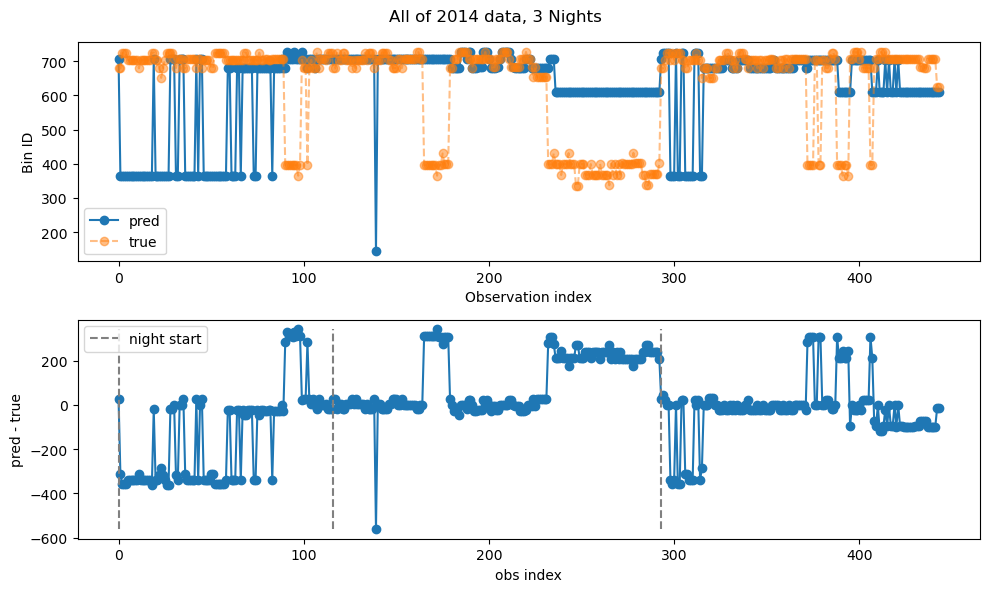

In [40]:
target_sequence = dataset.actions.detach().numpy()
eval_sequence = eval_actions
mask_first_obs = dataset.states[:, 0] == 0. 

fig, axs = plt.subplots(2, figsize=(10,6))
axs[0].plot(eval_sequence, marker='o', label='pred')
axs[0].plot(target_sequence, marker='o', linestyle='dashed', label='true', alpha=.5)
axs[0].set_xlabel('Observation index')
axs[0].set_ylabel('Bin ID')
axs[0].legend()

axs[1].plot(eval_sequence - target_sequence, marker='o')
axs[1].vlines(first_obs_in_night_indices, ymin=np.min(eval_sequence - target_sequence), ymax=np.max(eval_sequence - target_sequence), linestyle='--', color='grey', label='night start')
axs[1].legend()
axs[1].set_xlabel('obs index')
axs[1].set_ylabel('pred - true')

fig.tight_layout()
fig.suptitle(f'All of 2014 data, {dataset.n_nights} Nights')
fig.tight_layout()
fig.savefig(fig_outdir + 'learned_sequence.png')

In [26]:
dataset.n_nights

121